In [45]:
# https://jesusleal.io/2020/11/24/Longformer-with-IMDB/
# https://github.com/jlealtru/website_tutorials/blob/main/notebooks/Longformer%20with%20IMDB.ipynb

In [46]:
#import pandas as pd
import datasets
from datasets import load_dataset, DatasetDict, Dataset
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig
import torch.nn as nn
import torch
# from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
# import wandb
import os
import json
from transformers import PerceiverTokenizer, PerceiverModel, PerceiverConfig, PerceiverPreTrainedModel, PerceiverForSequenceClassification, TrainingArguments, Trainer, \
    DataCollatorWithPadding
import re


In [47]:

import os

os.environ["MASTER_ADDR"] = "localhost"

os.environ["MASTER_PORT"] = "9994" # modify if RuntimeError: Address already in use

os.environ["RANK"] = "0"

os.environ["LOCAL_RANK"] = "0"

os.environ["WORLD_SIZE"] = "1"



In [48]:
# define the training arguments

train_output_dir = "../ignored_dir/training_outputs/longformer_contract_nli"
if not os.path.exists(train_output_dir):
    os.mkdir(train_output_dir)
run_idx = len(os.listdir(train_output_dir)) + 1
run_idx = 45
run_path = os.path.join(train_output_dir, f"run_{run_idx}")
results_dir = os.path.join(run_path, "results")
logs_dir = os.path.join(run_path, "logs")
best_dir = os.path.join(run_path, "best")
print(f"saving to {results_dir}")
training_args = TrainingArguments(
    output_dir = results_dir,
    num_train_epochs = 5,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,    
    per_device_eval_batch_size= 8,
    # evaluation_strategy = "epoch",
    eval_strategy="steps",
    save_steps=200,
    eval_steps=400,
    disable_tqdm = False, 
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps = 4,
    fp16 = True,
    logging_dir=logs_dir,
    dataloader_num_workers = 0,
    # deepspeed="deepspeed.json",
)

saving to ../ignored_dir/training_outputs/longformer_contract_nli/run_45/results


In [49]:
ROOT_PATH = ".."

id2label = {0: "Entailment", 1: "Contradiction", 2: "NotMnetioned"}
label2id = {"Entailment": 0, "Contradiction": 1, "NotMentioned": 2}

def load_dataset_custom(dataset_name):
    if dataset_name == "contract-nli":
        def contract_nli_iterator(data):
            documents, labels = data['documents'], data['labels']
            for document in documents:
                id = document['id']
                file_name = document['file_name']
                text = document['text']
                spans = document['spans']
                annotation_sets = document['annotation_sets']
                document_type = document['document_type']
                url = document['url']
                for annotation_id, annotation_content in annotation_sets[0]['annotations'].items():
                    hypothesis = labels[annotation_id]['hypothesis']
                    choice = annotation_content['choice']
                    yield {
                        "id": id,
                        "file_name": file_name,
                        "text": text,
                        "spans": spans,
                        "document_type": document_type,
                        "url": url,
                        "hypothesis": hypothesis,
                        "labels": label2id[choice],
                    }            
        base_filepath = os.path.join(ROOT_PATH, "ignored_dir/data/contract-nli")
        train_filepath = os.path.join(base_filepath, "train.json")
        validation_filepath = os.path.join(base_filepath, "dev.json")
        test_filepath = os.path.join(base_filepath, "test.json")
        with open(train_filepath) as f:
            train_data = json.load(f)
        with open(validation_filepath) as f:
            validation_data = json.load(f)
        with open(test_filepath) as f:
            test_data = json.load(f)
        data = {
            "train": Dataset.from_generator(lambda: contract_nli_iterator(train_data)),
            "validation": Dataset.from_generator(lambda: contract_nli_iterator(validation_data)),
            "test": Dataset.from_generator(lambda: contract_nli_iterator(test_data)),
        }
        return DatasetDict(data)
    return None

contract_nli_dataset = load_dataset_custom("contract-nli")

In [50]:
contract_nli_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'file_name', 'text', 'spans', 'document_type', 'url', 'hypothesis', 'labels'],
        num_rows: 7191
    })
    validation: Dataset({
        features: ['id', 'file_name', 'text', 'spans', 'document_type', 'url', 'hypothesis', 'labels'],
        num_rows: 1037
    })
    test: Dataset({
        features: ['id', 'file_name', 'text', 'spans', 'document_type', 'url', 'hypothesis', 'labels'],
        num_rows: 2091
    })
})

In [51]:
# load model and tokenizer and define length of the text sequence
# ckpt_path = "../ignored_dir/training_outputs/longformer_snli_run_2_ckpt_1500"
ckpt_path = "../ignored_dir/training_outputs/longformer_contract_nli/run_45/results/checkpoint-1400"
# model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
model = LongformerForSequenceClassification.from_pretrained(ckpt_path,
                                                           num_labels=3,
                                                           gradient_checkpointing=False,
                                                           attention_window = 512,
                                                           max_position_embeddings=13000,
                                                           ignore_mismatched_sizes=True,
)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length = 13000)

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [52]:
# from parallelformers import parallelize

# parallelize(model, num_gpus=8, fp16=True, verbose='detail')

In [53]:
### roll positional embeddings over

if ckpt_path is None:
    tmp = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                            num_labels=3,
                                                            gradient_checkpointing=False,
                                                            attention_window = 512)
    tmp_data = tmp.longformer.embeddings.position_embeddings.weight.data.detach().clone()
    del tmp
    import gc
    gc.collect()
    torch.cuda.empty_cache()

    sshape, bshape = tmp_data.shape, model.longformer.embeddings.position_embeddings.weight.data.shape
    print("smaller positional embeddings shape", sshape)
    print("bigger positional embeddings shape", bshape)
    model.longformer.embeddings.position_embeddings.weight.data = tmp_data.repeat(bshape[0] // sshape[0] + 1, 1)[:bshape[0],:]
    print(model.longformer.embeddings.position_embeddings.weight.data.shape)

In [54]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
"""
def tokenization(batched_text):
    return tokenizer(batched_text['text'], batched_text['hypothesis'])

contract_nli_dataset_mapped = contract_nli_dataset.map(tokenization, batched = True, batch_size = len(contract_nli_dataset))
train_data, eval_data, test_data = contract_nli_dataset['train'], contract_nli_dataset['validation'], contract_nli_dataset['test']

ml = 0
for mode in contract_nli_dataset_mapped.keys():
    contract_nli_dataset_mapped_mode = contract_nli_dataset_mapped[mode]
    for e in tqdm(contract_nli_dataset_mapped_mode, total=len(contract_nli_dataset_mapped_mode)):
        l = len(e['input_ids'])
        ml = max(ml, l)
print(f"max sequence length is {ml}")
### max sequence length is 11998
"""

'\ndef tokenization(batched_text):\n    return tokenizer(batched_text[\'text\'], batched_text[\'hypothesis\'])\n\ncontract_nli_dataset_mapped = contract_nli_dataset.map(tokenization, batched = True, batch_size = len(contract_nli_dataset))\ntrain_data, eval_data, test_data = contract_nli_dataset[\'train\'], contract_nli_dataset[\'validation\'], contract_nli_dataset[\'test\']\n\nml = 0\nfor mode in contract_nli_dataset_mapped.keys():\n    contract_nli_dataset_mapped_mode = contract_nli_dataset_mapped[mode]\n    for e in tqdm(contract_nli_dataset_mapped_mode, total=len(contract_nli_dataset_mapped_mode)):\n        l = len(e[\'input_ids\'])\n        ml = max(ml, l)\nprint(f"max sequence length is {ml}")\n### max sequence length is 11998\n'

In [55]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], batched_text['hypothesis'], padding = 'max_length', truncation=True, max_length = 13000)

contract_nli_dataset_mapped = contract_nli_dataset.map(tokenization, batched = True, batch_size = len(contract_nli_dataset))
train_data, eval_data, test_data = contract_nli_dataset_mapped['train'], contract_nli_dataset_mapped['validation'], contract_nli_dataset_mapped['test']

In [56]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [57]:
# define accuracy metrics
"""
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # argmax(pred.predictions, axis=1)
    #pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
"""

import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np

snli_id2label = {0: "entailment", 1: "neutral", 2: "contradiction"}
contract_nli_id2label = {0: "Entailment", 1: "Contradiction", 2: "NotMnetioned"}
snli_2_contract_nli = {0: 0, 1: 2, 2: 1}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    predictions = [snli_2_contract_nli[p] for p in predictions]
    return accuracy.compute(predictions=predictions, references=labels)

In [58]:
# import deepspeed

# with deepspeed.zero.Init(config_dict_or_path="deepspeed.json", remote_device='cpu', enabled=True):
#    print("haha")

In [59]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


'cuda'

In [60]:
trainer.evaluate(eval_dataset=test_data)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.45 GiB. GPU 0 has a total capacity of 21.95 GiB of which 1.87 GiB is free. Including non-PyTorch memory, this process has 20.07 GiB memory in use. Of the allocated memory 7.47 GiB is allocated by PyTorch, and 12.05 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
### if this step runs into issues
### add https://github.com/microsoft/DeepSpeed/pull/5780
trainer.train(resume_from_checkpoint=ckpt_path)

/home/yan_xu_uk_qbe_com/scc_yan/virtual-env/lib/python3.10/site-packages/transformers/trainer.py:3108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(

Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1600,0.938600,0.957551,0.004100,0.462936
2000,0.909800,0.958638,0.004100,0.109517
2400,1.038100,0.957610,0.004100,0.462936


KeyboardInterrupt: 

In [ ]:
# save the best model
trainer.save_model(best_dir)

In [ ]:
ret = trainer.evaluate(eval_dataset=test_data)

In [1]:
import os
import json
### gather data
output_dir = "../ignored_dir/training_outputs/longformer_contract_nli/run_45/results"
ckpt = max(os.listdir(output_dir), key=lambda x: int(x.split('-')[-1]))
ckpt_path = os.path.join(output_dir, ckpt)
print(f"reading from {ckpt_path}")
json_path = os.path.join(ckpt_path, "trainer_state.json")
with open(json_path) as f:
    json_f = json.load(f)
log_history = json_f['log_history']

train_record = dict()
eval_record = dict()
lr_record = dict()
for h in log_history:
    try:
        loss = h['loss']
        lr = h['learning_rate']
        epoch = h['epoch']
        train_record[epoch] = loss
        lr_record[epoch] = lr
    except:
        eval_loss = h['eval_loss']
        epoch = h['epoch']
        eval_record[epoch] = eval_loss      

reading from ../ignored_dir/training_outputs/longformer_contract_nli/run_45/results/checkpoint-2400


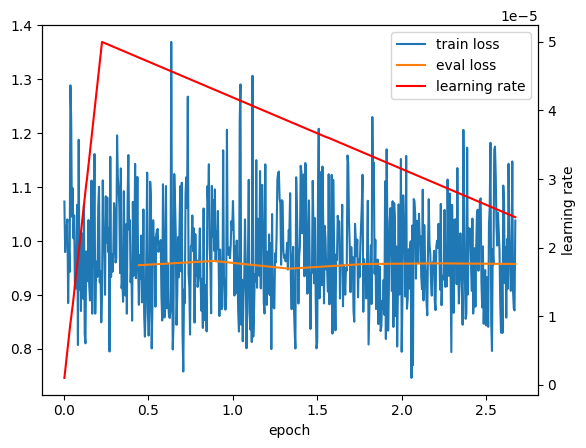

In [2]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

train_epoches = sorted(train_record.keys())
train_values = [train_record[k] for k in train_epoches]
ax1.plot(train_epoches, train_values, label='train loss')

eval_epoches = sorted(eval_record.keys())
eval_values = [eval_record[k] for k in eval_epoches]
ax1.plot(eval_epoches, eval_values, label='eval loss')
ax1.set_xlabel('epoch')


h1, l1 = ax1.get_legend_handles_labels()
hc1 = [e.get_color() for e in h1]

lr_epoches = sorted(lr_record.keys())
lr_values = [lr_record[k] for k in lr_epoches]
ax2.plot(lr_epoches, lr_values, label='learning rate', color='red')
ax2.set_ylabel('learning rate')

h2, l2 = ax2.get_legend_handles_labels()
hc2 = [e.get_color() for e in h2]

tmp, _ = ax2.get_legend_handles_labels()
tmp = tmp[0]

colors = hc1 + hc2
labels = l1 + l2
handles = [mlines.Line2D([], []) for _ in range(len(colors))]
for i, h in enumerate(handles):
    h.update_from(tmp)
    h.set_label(labels[i])
    h.set_color(colors[i])

plt.legend(handles, labels) # , bbox_to_anchor=(2.2, 0.5)) # , colors=['blue', 'orange', 'green', 'red'])

plt.savefig("longformer_contract_nli.png", bbox_inches = 'tight')